In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

## Loading the dataset

In [9]:
postings = pd.read_csv(r"Data\postings.csv")

In [10]:
postings.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')

In [11]:
postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


## Data Wrangling

In [13]:
postings["company_id"].head()

0     2774458.0
1           NaN
2    64896719.0
3      766262.0
4           NaN
Name: company_id, dtype: float64

In [14]:
postings["company_id"] = postings["company_id"].fillna(0) #filling NaN company_id to 0 for int casting (currently float)
postings["company_id"] = postings["company_id"].astype("int") #converting company_id to int

In [15]:
postings["formatted_experience_level"].isnull().sum()

29409

In [16]:
postings["formatted_experience_level"] = postings["formatted_experience_level"].fillna("Unknown") # filling unknown experience level

In [17]:
postings["location"]

0                   Princeton, NJ
1                Fort Collins, CO
2                  Cincinnati, OH
3               New Hyde Park, NY
4                  Burlington, IA
                   ...           
123844           Walnut Creek, CA
123845              United States
123846                Spokane, WA
123847       Texas, United States
123848    San Juan Capistrano, CA
Name: location, Length: 123849, dtype: object

In [18]:
postings[["City", "State"]] = postings["location"].str.split(",", expand = True, n=1) # Splitting location to City and State
postings["State"] = postings["State"].str.strip() # Removing whitespaces from State
postings = postings.loc[postings["State"].str.len() == 2] # keeping only rows with State abbreviation (CA, NY, etc.)

In [19]:
postings["State"]

0         NJ
1         CO
2         OH
3         NY
4         IA
          ..
123840    MD
123843    CA
123844    CA
123846    WA
123848    CA
Name: State, Length: 105090, dtype: object

In [20]:
postings = postings.loc[:,["job_id","company_id", "State", "formatted_experience_level", "work_type"]]
# getting only the columns needed

In [21]:
postings

,job_id,company_id,State,formatted_experience_level,work_type
0,921716,2774458,NJ,Unknown,FULL_TIME
1,1829192,0,CO,Unknown,FULL_TIME
2,10998357,64896719,OH,Unknown,FULL_TIME
3,23221523,766262,NY,Unknown,FULL_TIME
4,35982263,0,IA,Unknown,FULL_TIME
...,...,...,...,...,...
123840,3906266212,413796,MD,Entry level,CONTRACT
123843,3906266272,122451,CA,Mid-Senior level,CONTRACT
123844,3906267117,56120,CA,Mid-Senior level,FULL_TIME
123846,3906267131,90552133,WA,Mid-Senior level,FULL_TIME


## Joining secondary tables

In [23]:
# loading side tables
salaries = pd.read_csv(r"Data\Salaries_cleaned.csv")
companies = pd.read_csv(r"Data\companies.csv")
job_industries = pd.read_csv(r"Data\job_industries.csv")
industries = pd.read_csv(r"Data\industries.csv")
job_skills = pd.read_csv(r"Data\job_skills.csv")
skills = pd.read_csv(r"Data\skills.csv")
benefits = pd.read_csv(r"Data\benefits.csv")
employees = pd.read_csv(r"Data\employee_counts.csv")

In [24]:
companies.head(1)

,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm


In [25]:
postings = pd.merge(postings, companies, on= "company_id", how="inner") # joining companies
#even though no features from companies are used, there are more features linked on company_id, inner join got only matching rows
postings = pd.merge(postings, salaries, on="job_id", how="inner") #joining salaries (for salary prediction only rows which have salary)


In [26]:
job_industries.head(1)

,job_id,industry_id
0,3884428798,82


In [27]:
industries.loc[industries["industry_id"]==82]

,industry_id,industry_name
79,82,Book and Periodical Publishing


In [28]:
job_industries = pd.merge(job_industries, industries, on="industry_id", how="inner") #joining the names of industry to job_industries table

In [29]:
postings = pd.merge(postings, job_industries, on="job_id", how="inner") # joining the names of industry to postings

In [30]:
job_skills.head(1)

,job_id,skill_abr
0,3884428798,MRKT


In [31]:
skills.loc[skills["skill_abr"]=="MRKT",:]

,skill_abr,skill_name
27,MRKT,Marketing


In [32]:
job_skills = pd.merge(job_skills, skills, on="skill_abr", how="inner") # joining skill names to job_skills table

In [33]:
postings = pd.merge(postings, job_skills, on= "job_id", how="inner") # joining skill names to postings table

In [34]:
benefits.head(1)

,job_id,inferred,type
0,3887473071,0,Medical insurance


In [35]:
postings = pd.merge(postings, benefits, on= "job_id", how="left") #joining benefits to postings
# Used left join to keep job postings with no benefits

In [36]:
employees.head(1)

,company_id,employee_count,follower_count,time_recorded
0,391906,186,32508,1712346173


In [37]:
postings = pd.merge(postings, employees, on= "company_id", how="inner") #joining employee count and linkedIN followers to postings

In [38]:
postings.columns #list of columns after joining

Index(['job_id', 'company_id', 'State', 'formatted_experience_level',
       'work_type', 'name', 'description', 'company_size', 'state', 'country',
       'city', 'zip_code', 'address', 'url', 'salary_id', 'salary',
       'industry_id', 'industry_name', 'skill_abr', 'skill_name', 'inferred',
       'type', 'employee_count', 'follower_count', 'time_recorded'],
      dtype='object')

## Organizing data

In [40]:
postings = postings.loc[:,['job_id','employee_count','follower_count','work_type','formatted_experience_level','State','industry_name','skill_name','type','salary']]
postings #keeping only features used for modeling and job_id for grouping

,job_id,employee_count,follower_count,work_type,formatted_experience_level,State,industry_name,skill_name,type,salary
0,921716,402,2351,FULL_TIME,Unknown,NJ,Real Estate,Marketing,NaN,38480.0
1,921716,402,2351,FULL_TIME,Unknown,NJ,Real Estate,Sales,NaN,38480.0
2,10998357,15,40,FULL_TIME,Unknown,OH,Restaurants,Management,NaN,55000.0
3,10998357,15,40,FULL_TIME,Unknown,OH,Restaurants,Manufacturing,NaN,55000.0
4,23221523,222,2427,FULL_TIME,Unknown,NY,Law Practice,Other,401(k),157500.0
...,...,...,...,...,...,...,...,...,...,...
356739,3906267117,185,2818,FULL_TIME,Mid-Senior level,CA,Law Practice,Business Development,Paid maternity leave,157500.0
356740,3906267224,862,79661,FULL_TIME,Mid-Senior level,CA,Manufacturing,Marketing,NaN,72500.0
356741,3906267224,875,81300,FULL_TIME,Mid-Senior level,CA,Manufacturing,Marketing,NaN,72500.0
356742,3906267224,874,81918,FULL_TIME,Mid-Senior level,CA,Manufacturing,Marketing,NaN,72500.0


In [41]:
df = postings #simplifying naming for postings table

In [42]:
# for each job_id gets dataframe with job_id and all its unique skills, industries and benefits separated with comma
df_industries = df.groupby("job_id")["industry_name"].apply(lambda x: ",".join(x.unique().astype(str))).reset_index()
df_skills = df.groupby("job_id")["skill_name"].apply(lambda x: ",".join(x.unique().astype(str))).reset_index()
df_benefits = df.groupby("job_id")["type"].apply(lambda x: ",".join(x.unique().astype(str))).reset_index()


In [43]:
df = df.drop(columns=["industry_name","skill_name", "type"]) #dropping original columns

In [44]:
# joining industries, skills and benefits separated by comma
df = pd.merge(df,df_industries, on="job_id")
df = pd.merge(df,df_skills, on="job_id")
df = pd.merge(df,df_benefits, on="job_id")

In [45]:
#renaming columns for better readability
df = df.rename(columns={"formatted_experience_level": "experience_level", "State": "state", "type": "benefit_name"})

In [46]:
df.head(5)

,job_id,employee_count,follower_count,work_type,experience_level,state,salary,industry_name,skill_name,benefit_name
0,921716,402,2351,FULL_TIME,Unknown,NJ,38480.0,Real Estate,"Marketing,Sales",nan
1,921716,402,2351,FULL_TIME,Unknown,NJ,38480.0,Real Estate,"Marketing,Sales",nan
2,10998357,15,40,FULL_TIME,Unknown,OH,55000.0,Restaurants,"Management,Manufacturing",nan
3,10998357,15,40,FULL_TIME,Unknown,OH,55000.0,Restaurants,"Management,Manufacturing",nan
4,23221523,222,2427,FULL_TIME,Unknown,NY,157500.0,Law Practice,Other,401(k)


In [47]:
# dropping duplicated job postings (duplicate job_id)
filter = df.duplicated(subset="job_id")
filter = filter[filter==True].index.tolist()
df = df.drop(filter)

In [48]:
df = df.drop(columns="job_id")

In [49]:
df["benefit_name"] = df["benefit_name"].replace("nan", "None") #replacing nan with None for readability

In [50]:
for i in df["work_type"].unique(): # getting salary mean for each work_type
    print(i, df.loc[df["work_type"] == i,"salary"].mean())
df["work_type"].value_counts()

FULL_TIME 95586.72860175975
INTERNSHIP 56485.49777777779
PART_TIME 58777.8446098049
TEMPORARY 72593.03267045454
CONTRACT 97990.73985974754
OTHER 74417.7029752066
VOLUNTEER 46788.333333333336


work_type
FULL_TIME     23526
CONTRACT       2852
PART_TIME      1999
TEMPORARY       352
INTERNSHIP      180
OTHER           121
VOLUNTEER         3
Name: count, dtype: int64

In [51]:
# only contract and full time rows are kept so job postings represent about 40h/week of work
df = df.loc[df["work_type"].isin(("CONTRACT","FULL_TIME"))]

In [52]:
df.to_csv("Dataset_cleaned.csv", index= False, index_label=False)

## Encoding categorical data

In [54]:
# creating dummies for multivalues columns (industries, skills, benefits)
in_dum = df["industry_name"].str.get_dummies(sep=",")
in_dum = in_dum.add_prefix("in_")

sk_dum = df["skill_name"].str.get_dummies(sep=",")
sk_dum = sk_dum.add_prefix("sk_")

be_dum = df["benefit_name"].str.get_dummies(sep=",")
be_dum = be_dum.add_prefix("be_")
# joining dummy tables to dataframe
df = df.join(in_dum)
df = df.join(sk_dum)
df = df.join(be_dum)
# dropping unencoded columns
df = df.drop(columns=["industry_name","skill_name","benefit_name"])

In [55]:
cat_columns = df.select_dtypes(include=["object"]).columns.to_list() # getting list of categorical columns
for col in cat_columns:
    dum = pd.get_dummies(df[col], prefix=col[:2], dtype=int) # creates dummy table and joins it to dataframe for each categorical column
    df = df.join(dum)
df = df.drop(columns = cat_columns) # drops unencoded categorical columns

In [56]:
df.isnull().sum().sum() # checking for nulls in the dataframe

0

In [57]:
df.info() # checking that all columns are numerical

<class 'pandas.core.frame.DataFrame'>
Index: 26378 entries, 0 to 356740
Columns: 492 entries, employee_count to st_WY
dtypes: float64(1), int32(60), int64(431)
memory usage: 93.2 MB


In [58]:
df["salary"].describe(percentiles=[0.25,0.5,0.75,0.95]) # describing target

count     26378.000000
mean      95846.651269
std       57808.055704
min       10500.000000
25%       53040.000000
50%       81120.000000
75%      124400.000000
95%      200000.000000
max      750000.000000
Name: salary, dtype: float64

In [59]:
df = df.loc[df["salary"]<=200_000] # dropping outliers (salaries higher than 200 000)

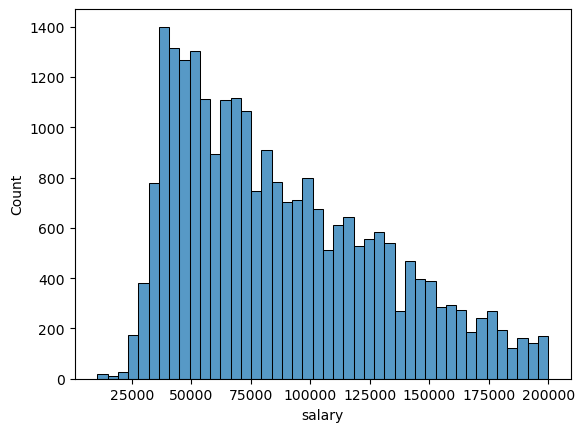

In [60]:
# salary distribution
plt.figure()
sns.histplot(df["salary"])
plt.show()

In [61]:
df.corr()["salary"].abs().sort_values(ascending=False) # correlation of the features

salary                                       1.000000
ex_Entry level                               0.332259
ex_Mid-Senior level                          0.297878
sk_Information Technology                    0.229727
sk_Engineering                               0.220155
                                               ...   
in_Wholesale Alcoholic Beverages             0.000055
in_Primary Metal Manufacturing               0.000038
in_Communications Equipment Manufacturing    0.000024
in_Writing and Editing                       0.000005
in_Animation and Post-production                  NaN
Name: salary, Length: 492, dtype: float64

### Because of low correlation of features and non normal distribution of target variable (without any transformations) classification was chosen for prediction

In [63]:
bins = [0, 50000, 100000, max(df["salary"])] # creating bins for salary (<=50k, (50, 100k], >100k)
labels = [0, 1, 2]
df["salary"] = pd.cut(df["salary"], bins=bins, labels=labels)

In [64]:
df.head(3)

,employee_count,follower_count,salary,in_ Actuarial Services,in_ Ceramics and Concrete Manufacturing,in_ Coating,in_ Construction,in_ Control,in_ Electrical,in_ Forestry,...,st_SD,st_TN,st_TX,st_UT,st_VA,st_VT,st_WA,st_WI,st_WV,st_WY
0,402,2351,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,40,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,222,2427,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df.salary.value_counts() # number of records for each target bin

salary
1    10778
2     8578
0     5784
Name: count, dtype: int64

## Modeling

In [67]:
# splitting features and target
features = df.drop(columns="salary")
target = df["salary"]

In [68]:
x_train,x_test,y_train,y_test = train_test_split(features, target, test_size=0.25, random_state=42) # splitting the dataset 75:25

In [69]:
# creating pipeline for model and scaling
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", None)
]) 

In [70]:
# parameters for each model
params =[
{"model":[SVC(random_state=42)], #Support Vector classifier model
 "model__C":[1, 2], # C hyperparameter 
 "model__kernel": ['rbf'], # kernel hyperparameter
 "model__gamma": ["scale"]} # gamma hyperparameter
,
{"model":[RandomForestClassifier(n_jobs=-1, random_state=42)], # Random forest classifier model
 "model__n_estimators":[300, 400], # number of trees
 "model__max_depth": [50, None],  # maximum number of branches
 "model__class_weight": ["balanced", None]}
,
{"model":[XGBClassifier(n_jobs=-1, random_state=42)],
 "model__n_estimators": [200, 300], # number boosting rounds
 "model__learning_rate": [0.01, 0.1, 1], # learning rate
 "model__max_depth": [None, 50]}] # maximum tree branches

In [71]:
grid = GridSearchCV(estimator=pipe, param_grid=params, scoring="accuracy", cv = 3, n_jobs=-1, verbose=3)
grid.fit(x_train,y_train)

Fitting 3 folds for each of 22 candidates, totalling 66 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [SVC(random_state=42)], 'model__C': [1, 2],
                          'model__gamma': ['scale'], 'model__kernel': ['rbf']},
                         {'model': [RandomForestClassifier(n_jobs=-1,
                                                           random_state=42)],
                          'model__class_weight': ['balanced', None],
                          'model__max_depth': [50, None],
                          'model__n_es...
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None, n_jobs=-1,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...)],
                          'model__learning_rate': [0.01, 0.1, 1],
                          'model__max_depth': [None, 50],
                          'model__n_estimators': [200, 300]}],
             scoring='accuracy', verbose=3)

In [72]:
grid.best_params_ # best performing model and its parameters

{'model': RandomForestClassifier(n_jobs=-1, random_state=42),
 'model__class_weight': None,
 'model__max_depth': None,
 'model__n_estimators': 400}

In [73]:
y_pred = grid.best_estimator_.predict(x_test) # predicting salary for test data using best performing model
labels = ["0 to 50000", "50001 to 100000", "100001 and higher"]
conf_matr = confusion_matrix(y_test,y_pred) # creating confusion matrix
print(classification_report(y_test,y_pred, target_names = labels)) # Classification report

                   precision    recall  f1-score   support

       0 to 50000       0.71      0.60      0.65      1455
  50001 to 100000       0.63      0.70      0.66      2705
100001 and higher       0.72      0.70      0.71      2125

         accuracy                           0.68      6285
        macro avg       0.69      0.67      0.67      6285
     weighted avg       0.68      0.68      0.68      6285



In [74]:
print(accuracy_score(y_pred,y_test)) # accuracy of the best performing model

0.6762132060461417


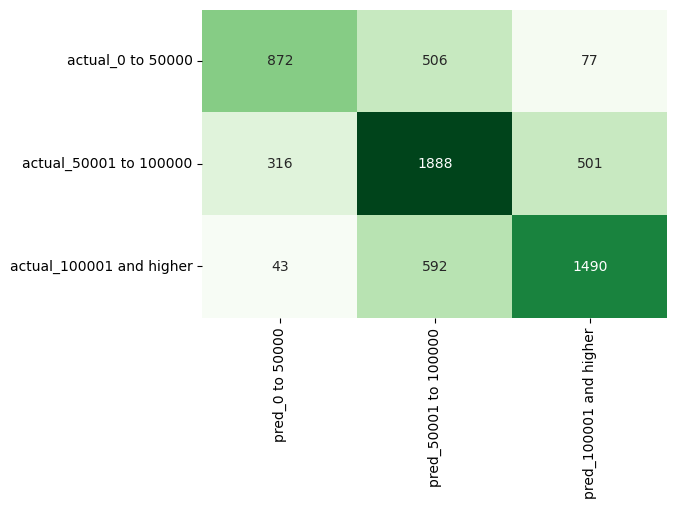

In [75]:
#Graph of confusion matrix
actual = [f"actual_{el}" for el in labels]
predict = [f"pred_{el}" for el in labels]
plt.figure(figsize=(6,4))
sns.heatmap(conf_matr,xticklabels=predict, yticklabels=actual, annot=True, cbar=False, fmt="d", cmap="Greens")
plt.show()

## Overview of all models

In [77]:
# overview of all models (Random forest, XGB, SVC using different settings)
models = pd.DataFrame(grid.cv_results_)
models = models.loc[:,["params", "mean_test_score", "rank_test_score"]]
models = models.sort_values(by="rank_test_score")
models

,params,mean_test_score,rank_test_score
9,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.654680,1
7,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.654521,2
5,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.653142,3
3,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.652983,4
8,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.652824,5
4,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.652453,6
6,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.652188,7
2,"{'model': RandomForestClassifier(n_jobs=-1, ra...",0.652029,8
16,"{'model': XGBClassifier(base_score=None, boost...",0.647786,9
17,"{'model': XGBClassifier(base_score=None, boost...",0.647627,10
